# This notebook examines state-specific trends in the processed general.txt file (general.pkl)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import os
import re
import cpi

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')

# Agency prefix dictionary:
with open(processed_path + 'agency_dict.pkl', 'rb') as f_r:
    agency_dict = pickle.load(f_r)
# Entity code dictionary:
with open(processed_path + 'entity_dict.pkl', 'rb') as f_r:
    entity_dict = pickle.load(f_r)

Fields carried over from processing general.txt

In [2]:
# for i in df_general.columns:
#     print(i)

Adjust `DOLLARTHRESHOLD` and `TOTFEDEXPEND_ADJUSTED` for inflation

In [3]:
df_general['DOLLARTHRESHOLD_ADJUSTED'] = df_general.apply(lambda x: cpi.inflate(x.DOLLARTHRESHOLD, x.AUDITYEAR), axis=1)
df_general['TOTFEDEXPEND_ADJUSTED'] = df_general.apply(lambda x: cpi.inflate(x.TOTFEDEXPEND, x.AUDITYEAR), axis=1)

In [4]:
# Remove territories/islands
df_analysis = df_general[~df_general['STATE'].isin(['AS','MP','FM','PR','GU','PW','MH','VI'])]

## Calculate relative numbers of audits and total expenditure

In [28]:
series_state_pct_audits = 100 * df_analysis.groupby('STATE').size().sort_values(ascending=False) / len(df_general)
series_dict = {'PCT_ALL_AUDITS': series_state_pct_audits}
series_state_pct_expend = 100 * df_analysis.groupby('STATE')\
    ['TOTFEDEXPEND_ADJUSTED'].sum().sort_values(ascending=False) / \
    df_general['TOTFEDEXPEND_ADJUSTED'].sum() 
series_dict['PCT_FEDEXPEND'] = series_state_pct_expend

## Risk

In [30]:
df_risk_state = df_analysis.groupby('STATE')['LOWRISK'].value_counts().sort_index().unstack()
series_risk_state_norm = 100 * df_risk_state['N'] / len(df_general[df_general['LOWRISK'] == 'N'])
series_dict['PCT_HIGH_RISK'] = series_risk_state_norm

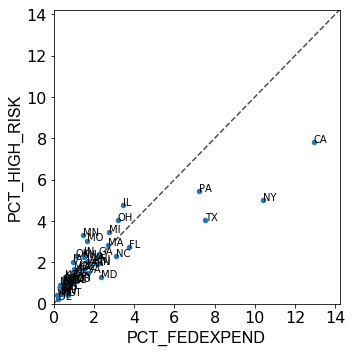

In [38]:
series1 = 'PCT_FEDEXPEND'
series2 = 'PCT_HIGH_RISK'

fig, axes = plt.subplots(figsize=(5, 5))
df_plot = pd.concat(
    [series_dict[series1].rename(series1), series_dict[series2].rename(series2)], 
    axis=1, sort=True
)
axes_max = max(max(series_dict[series1]), max(series_dict[series2]))
df_plot.dropna(inplace=True)
plot = df_plot.plot(
    x=series1, y=series2, kind='scatter', fontsize=16, ax=axes
)
for i, point in df_plot.iterrows():
    axes.text(point[series1], point[series2], str(i))
plot.set_xlabel(series1, fontsize=16, fontname='Arial')
plot.set_ylabel(series2, fontsize=16, fontname='Arial')
plot.set_ylim(bottom=0, top=1.1*axes_max)
plot.set_xlim(left=0, right=1.1*axes_max)
axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3")

plt.tight_layout()
plt.show()

## Financial statements

What are the possible bases of accounting that can be used?

In [10]:
set(df_analysis['SP_FRAMEWORK'])

{'', 'CASH', 'CONTRACTUAL', 'OTHER', 'REGULATORY', 'TAX'}

Filter data based on a particular basis of accounting framework

In [91]:
framework = 'CASH'
df_financial = df_analysis[df_analysis['SP_FRAMEWORK'] == framework]
if framework != '':
    print('Number of audits prepared according to a %s special framework: %s' %(framework, len(df_financial)))

Filter by whether special framework was required by state law (only for special purpose frameworks)

In [92]:
# if framework != '':
#     df_financial = df_financial[df_financial['SP_FRAMEWORK_REQUIRED'] == 'Y']

In [93]:
fs_series_dict = {}

###############################################################################
# Calculate general numbers: percent of all audits and total expenditure
###############################################################################
series_state_size = df_financial.groupby('STATE').\
    size().sort_values(ascending=False) / len(df_general) * 100
fs_series_dict['% all audits'] = series_state_size
series_state_expenditures = df_financial.groupby('STATE')\
    ['TOTFEDEXPEND_ADJUSTED'].sum().sort_values(ascending=False) / \
    df_general['TOTFEDEXPEND_ADJUSTED'].sum() * 100
fs_series_dict['% total expenditure'] = series_state_expenditures
###############################################################################

###############################################################################
# Get percent of A/D audit opinions on financial statement preparation and 
# financial issues
###############################################################################
if framework == '':
    sortby_fs = 'TYPEREPORT_FS'
else:
    sortby_fs = 'TYPEREPORT_SP_FRAMEWORK'
ad_op_list = [
    i for i in set(df_financial[sortby_fs]) 
    if ('A' in i) or ('D' in i)
]
df_state_fs = df_financial.groupby('STATE')\
    [sortby_fs].value_counts().unstack()
series_state_ad_fs = df_state_fs[ad_op_list]\
    .sum(axis=1).div(df_state_fs.sum(axis=1)).sort_values(ascending=False)
series_state_ad_fs_norm = series_state_ad_fs * 100
fs_series_dict[
    '%% of audits with >=1\nA or D opinion on\n%s' %sortby_fs
] = series_state_ad_fs_norm

# Get percent of financial issues
for op_state in [
    'GOINGCONCERN','REPORTABLECONDITION', 'MATERIALWEAKNESS',
    'MATERIALNONCOMPLIANCE'
]:
    df_op_state = df_financial.groupby('STATE')[op_state].value_counts().sort_index().unstack()
    df_op_state_norm = df_op_state.div(df_op_state.sum(axis=1), axis=0) * 100
    if op_state == 'MATERIALWEAKNESS':
        series_op_state = df_op_state_norm[
            [i for i in df_op_state_norm.columns if i in ['2', '3', 'X', 'Y']]
        ].sum(axis=1)
    else:
        series_op_state = df_op_state_norm['Y']
    if op_state == 'LOWRISK':
        fs_series_dict_key = '% LOWRISK audits'
    else:
        fs_series_dict_key = '% of audits with >= 1\n' + op_state
    fs_series_dict[fs_series_dict_key] = series_op_state
###############################################################################

print(fs_series_dict.keys())

dict_keys(['% all audits', '% total expenditure', '% of audits with >=1\nA or D opinion on\nTYPEREPORT_FS', '% of audits with >= 1\nGOINGCONCERN', '% of audits with >= 1\nREPORTABLECONDITION', '% of audits with >= 1\nMATERIALWEAKNESS', '% of audits with >= 1\nMATERIALNONCOMPLIANCE'])


In [169]:
series_1 = '% all audits'
series_2 = '% of audits with >= 1\nMATERIALWEAKNESS'

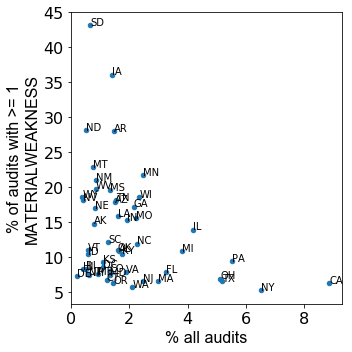

In [170]:
fig, axes = plt.subplots(figsize=(5, 5))
df_plot = pd.concat(
    [fs_series_dict[series_1].rename('series1'), fs_series_dict[series_2].rename('series2')], 
    axis=1, sort=True
)
df_plot.dropna(inplace=True)
# df_plot.drop(index='000', inplace=True)  # Drop obvious outlier for entities
plot = df_plot.plot(
    x='series1', y='series2', kind='scatter', fontsize=16, ax=axes
)
for i, point in df_plot.iterrows():
    axes.text(point['series1'], point['series2'], str(i))
plot.set_xlabel(series_1, fontsize=16, fontname='Arial')
plot.set_ylabel(series_2, fontsize=16, fontname='Arial')
plot.set_xlim(left=0.)
plt.tight_layout()
plt.show()

In [171]:
df_plot.sort_values('series2', ascending=False)
# state = 'AR'
# len(df_financial[df_financial['STATE'] == state]['TOTFEDEXPEND_ADJUSTED'])
# df_financial[df_financial['STATE'] == state]['TOTFEDEXPEND_ADJUSTED'].sum()
# df_financial[df_financial['STATE'] == state][
#     [
#         'AUDITYEAR','STATE','AUDITEENAME', 'EIN','TYPEOFENTITY','TOTFEDEXPEND',
#         'TYPEREPORT_SP_FRAMEWORK'
# #         'TYPEREPORT_FS'
#     ]
# ]
# df_financial[
#     (df_financial['STATE'] == state) & \
#     (df_financial['MATERIALWEAKNESS'] == 'Y')
# #     (df_financial['MATERIALNONCOMPLIANCE'] == 'Y')
# #     (df_financial['REPORTABLECONDITION'] == 'Y')
# #     (df_financial['TYPEREPORT_FS'].str.contains('A|D', regex=True))
# ]['TYPEOFENTITY'].value_counts()

,series1,series2
SD,0.662239,43.145379
IA,1.414192,36.089084
ND,0.511323,28.184788
AR,1.460839,28.068599
MT,0.768059,22.848711
MN,2.469050,21.695014
NM,0.872924,21.005877
WV,0.861114,19.797728
MS,1.345475,19.613407
WY,0.389279,18.633160


Calculate quantities that can be calculated for all audits

In [31]:
series_dict = {}

###############################################################################
# Calculate general numbers: percent of all audits and total expenditure
###############################################################################
series_state_size = df_analysis.groupby('STATE').\
    size().sort_values(ascending=False) / len(df_general) * 100
series_dict['% all audits'] = series_state_size
series_state_expenditures = df_analysis.groupby('STATE')\
    ['TOTFEDEXPEND_ADJUSTED'].sum().sort_values(ascending=False) / \
    df_general['TOTFEDEXPEND_ADJUSTED'].sum() * 100
series_dict['% total expenditure'] = series_state_expenditures
###############################################################################

###############################################################################
# Get opinion on major program compliance
###############################################################################
ad_op_list = [
    i for i in set(df_analysis['TYPEREPORT_MP']) if ('A' in i) or ('D' in i)
]
df_state_mp = df_analysis.groupby('STATE')\
    ['TYPEREPORT_MP'].value_counts().unstack()
series_state_ad_mp = df_state_mp[ad_op_list]\
    .sum(axis=1).div(df_state_mp.sum(axis=1)).sort_values(ascending=False)
series_state_ad_mp_norm = series_state_ad_mp * 100
series_dict[
    '%% of audits with >=1\nA or D opinion on TYPEREPORT_MP'
] = series_state_ad_mp_norm

###############################################################################
# Get percent of risk for low-risk designation and major program compliance 
# issues
###############################################################################
for op_state in [
    'LOWRISK', 'MATERIALWEAKNESS_MP', 'REPORTABLECONDITION_MP', 'QCOSTS'
]:
    df_op_state = df_analysis.groupby('STATE')\
        [op_state].value_counts().sort_index().unstack()
    df_op_state_norm = 100 * \
        df_op_state.div(df_op_state.sum(axis=1), axis=0) * 100
    if op_state == 'MATERIALWEAKNESS':
        series_op_state = df_op_state_norm[
            [i for i in df_op_state_norm.columns if i in ['2', '3', 'X', 'Y']]
        ].sum(axis=1)
    else:
        series_op_state = df_op_state_norm['Y']
    if op_state == 'LOWRISK':
        series_dict_key = '% LOWRISK audits'
    else:
        series_dict_key = '% of audits with >= 1\n' + op_state
    series_dict[series_dict_key] = series_op_state
###############################################################################
print(series_dict.keys())

dict_keys(['% all audits', '% total expenditure', '%% of audits with >=1\nA or D opinion on TYPEREPORT_MP', '% LOWRISK audits', '% of audits with >= 1\nMATERIALWEAKNESS_MP', '% of audits with >= 1\nREPORTABLECONDITION_MP', '% of audits with >= 1\nQCOSTS'])


In [22]:
series_1 = '% all audits'
series_2 = '% of audits with >=1\nA or D opinion on TYPEREPORT_MP'

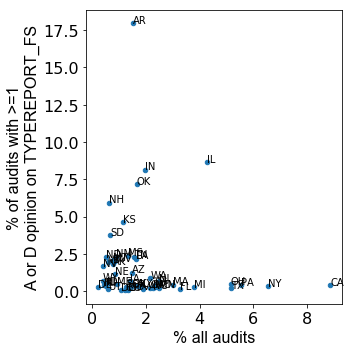

In [23]:
fig, axes = plt.subplots(figsize=(5, 5))
df_plot = pd.concat(
    [series_dict[series_1].rename('series1'), series_dict[series_2].rename('series2')], 
    axis=1, sort=True
)
df_plot.dropna(inplace=True)
# df_plot.drop(index='000', inplace=True)  # Drop obvious outlier for entities
plot = df_plot.plot(
    x='series1', y='series2', kind='scatter', fontsize=16, ax=axes
)
for i, point in df_plot.iterrows():
    axes.text(point['series1'], point['series2'], str(i))
plot.set_xlabel(series_1, fontsize=16, fontname='Arial')
plot.set_ylabel(series_2, fontsize=16, fontname='Arial')
plt.tight_layout()
plt.show()